In [2]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from control.matlab import *
import control 

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

## 1. System Identification ##

In [3]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

re = 10 # repeated time for measurement
y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# simulate the ERA system by using control package
sysERA = ss(Ar,Br,Cr,Dr,1)
y = np.zeros((time.shape[0],p,q))
for qi in range(q):
    y[:,:,qi],t = impulse(sysERA,np.arange(time.shape[0]),input=qi)

Text(0.5, 1.0, 'third mass')

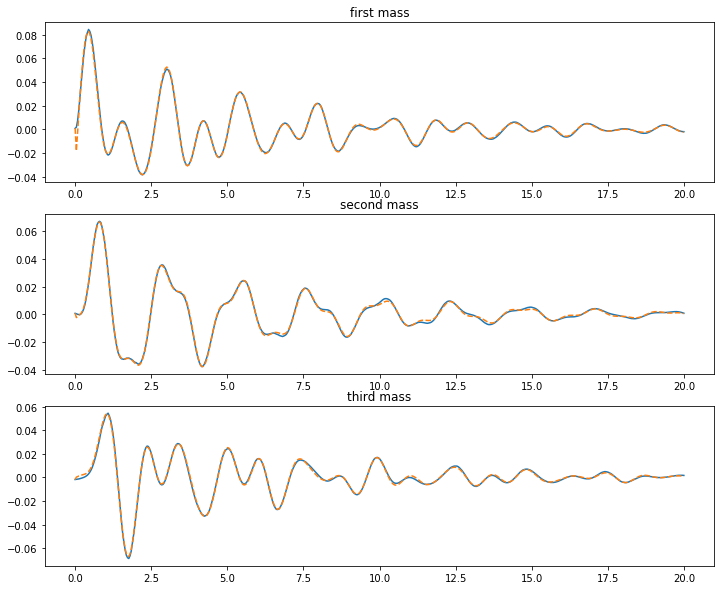

In [4]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_1[:,0])
ax1.plot(time, y[:,0,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, y[:,1,0], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, y[:,2,0], '--')
ax3.set_title('third mass')

In [5]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

In [6]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [7]:
## MPC initialization and casadi objective function ##

Q = 10                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 1                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 30                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [8]:
Q[2,2] = 0
S[2,2] = 0

In [9]:
# delta_u changing rate per step constraints
lb_u = -3*np.ones((nu,1))
ub_u = 3*np.ones((nu,1))

_lbg = -3*np.ones((nu,1))
_ubg = 3*np.ones((nu,1))

In [10]:
## create optimization problem ##
def casadi_setting_seq(nx,nu): # reference_signal
    
    #X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("delta_U",N*nu,1)
    xt = SX.sym("xt",nx,1)
    reference_signal = SX.sym("r",N,ny)
    
    J = 0
    
    lb_X = [] # lower bound for xt.
    ub_X = [] # upper bound for xt
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    x_step = xt # init step
    for k in range(N):
        # 01 
        #x_k = X[k*nx:(k+1)*nx,:]
        #x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        delta_u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
        J += stage_cost_fcn(x_step,delta_u_k,reference_signal[k,:])
        # 02

        # 03 next state
        
        # 03

        # 04
        g.append(x_step[10:] + delta_u_k)
        lb_g.append(_lbg)
        ub_g.append(_ubg)
        # 04
        x_step = system(x_step,delta_u_k)
        # 05

        lb_U.append(lb_u)
        ub_U.append(ub_u)
        # 05
    #lb_X.append(lb_x)
    #ub_X.append(ub_x)
    x_terminal = x_step
    J += terminal_cost_fcn(x_terminal,reference_signal[-1,:])
    #lb_X.append(lb_x)
    #ub_X.append(ub_x)
    return lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,reference_signal

In [11]:
#X = SX.sym("X",(N+1)*nx,1)
delta_U = SX.sym("delta_U",N*nu,1)
xt = SX.sym("xt",nx,1)
reference_signal = SX.sym("r",N,ny)
    
J = 0
    
lb_X = [] # lower bound for xt.
ub_X = [] # upper bound for xt
lb_U = [] # lower bound for delta_U
ub_U = [] # upper bound for delta_U
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g
    
x_step = xt # init step
k = 0
delta_u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
J += stage_cost_fcn(x_step,delta_u_k,reference_signal[k,:])
        # 02


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equa

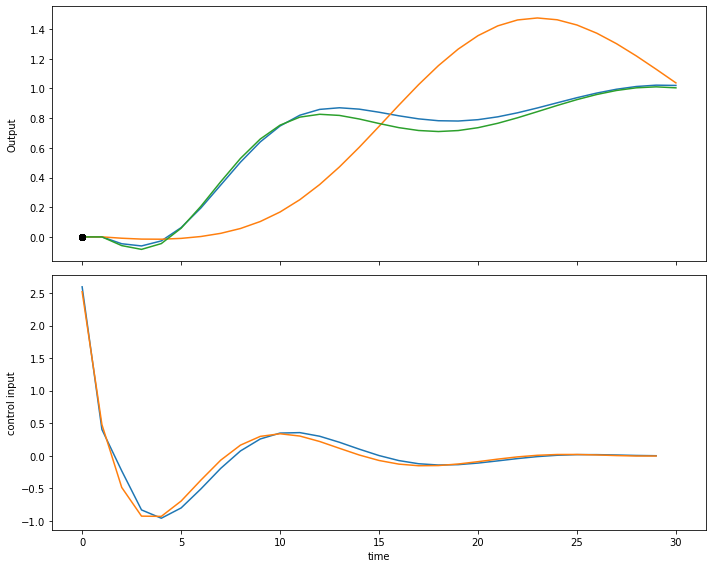

In [12]:
## test the functional solver production ##
reference = np.ones((N,ny))

lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,param = casadi_setting_seq(nx,nu)
# Casadi solver
x_0 = np.zeros((nx,1))
lb_X.append(x_0)
ub_X.append(x_0)

lbx = vertcat(*lb_X,*lb_U)
ubx = vertcat(*lb_X,*ub_U)
x = vertcat(xt,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)
#reference = vertcat(*reference)
param = vertcat(param)

prob = {'f':J,'p':param,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)

#X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

x_test = np.zeros((nx,1))

for n in range(N):
    Y = np.hstack((Y,Cb@x_test))
    x_test = Ab@x_test + Bb@(delta_U[n]).reshape(2,1)
# visulization of the result   

fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

In [13]:
N_sim = 500 # total simulation step
time = np.linspace(1,20,num = N_sim)
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))
# constant tracking
#REFERENCE[:,150:] = 2
#REFERENCE[:,400:] = 1
# trigonometric tracking
REFERENCE[0,:] = np.array(np.sin(np.linspace(-3*np.pi, 3*np.pi, N_sim+N-1))).T
REFERENCE[1,:] = np.array(np.sin(np.linspace(-3*np.pi+2*np.pi/3, 3*np.pi+2*np.pi/3, N_sim+N-1))).T
REFERENCE[2,:] = np.array(np.sin(np.linspace(-3*np.pi+2*2*np.pi/3, 3*np.pi+2*2*np.pi/3, N_sim+N-1))).T
# linear tracking
#REFERENCE[:,0:100] = 0
#REFERENCE[:,100:250] = np.linspace(0,3,250-100)
#REFERENCE[:,250:400] = np.linspace(3,0,400-250)
#REFERENCE[:,400:] = 0
# Acceleration signal
#REFERENCE[:,0:150] = 0
#REFERENCE[:,150:350] = (np.linspace(0,2.5,200))**2
#REFERENCE[:,350:] = 0

#################################### reference change test

In [14]:
%%time
## MPC main loop ##
x_0 = np.zeros((nx,1))
#u_0 = np.zeros((nu,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])



for i in range(N_sim-1):
    ############## create casadi solver
    reference = REFERENCE[:,i:i+N].T
    lb_U,ub_U,lb_X,ub_X,lb_g,ub_g,g,delta_U,xt,J,param = casadi_setting_seq(nx,nu)
    
    
    # Casadi solver
    lb_X.append(x_0)
    ub_X.append(x_0)
    
    lbx = vertcat(*lb_X,*lb_U)
    ubx = vertcat(*lb_X,*ub_U)
    x = vertcat(xt,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)
    
    if i == 0:
        prob = {'f':J,'p':param,'x':x,'g':g}
        solver = nlpsol('solver','ipopt',prob)

    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,p=reference)
    ###############
    
    _xt = res['x'][:nx].full()
    
    del_U = res['x'][nx:].full().reshape(N, nu)
    del_u = (del_U[0,:]).reshape(nu,1)
    
    res_delta_u.append(del_u)
    u_st = (_xt[10:]+del_u).reshape(nu,1)
    
    #u_0 = ((xt[Ar.shape[0]:]).reshape(nu,1)+del_u).reshape(nu,1)
    
    res_u.append(u_st)
    
    #x_next = Ab@x_0 + Bb@del_u # test on model
    
    # update the x_next
    # simulate the original system
    sys.simulate(time[i:i+2], (u_st).reshape(1,nu))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (del_u).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    #x_next = system(x_0,del_u)
    
    assert np.max(x_next[10:nx]) < 6 or np.min(x_next[10:nx]) > -4
    
    res_x.append(x_next)
    
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   3 1.4408737e+002 0.00e+000 2.30e-003  -2.5 2.06e-001    -  9.73e-001 1.00e+000f  1
   4 1.4407886e+002 0.00e+000 6.84e-014  -3.8 1.43e-001    -  1.00e+000 1.00e+000f  1
   5 1.4407876e+002 0.00e+000 9.93e-014  -5.7 1.89e-002    -  1.00e+000 1.00e+000f  1
   6 1.4407876e+002 0.00e+000 1.02e-013  -5.7 3.03e-004    -  1.00e+000 1.00e+000h  1
   7 1.4407876e+002 0.00e+000 5.99e-014  -8.6 2.41e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0890233018328114e+002   1.4407876439899397e+002
Dual infeasibility......:  5.9851255852129064e-014   7.9183750948119518e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5503812816321613e-009   3.3741774228839856e-009
Overall NLP error.......:  2.5503812816321613e-009   3.3741774228839856e-009


Number of objective function evaluations             = 8
Number of objective gradi

   5 9.9555841e+001 0.00e+000 2.34e-014  -3.8 1.73e-001    -  1.00e+000 1.00e+000f  1
   6 9.9555607e+001 0.00e+000 7.33e-014  -5.7 3.20e-002    -  1.00e+000 1.00e+000f  1
   7 9.9555606e+001 0.00e+000 6.58e-014  -5.7 9.91e-004    -  1.00e+000 1.00e+000h  1
   8 9.9555606e+001 0.00e+000 9.27e-014  -8.6 4.71e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  4.6776485861402868e+001   9.9555606465788188e+001
Dual infeasibility......:  9.2653234558019328e-014   1.9719627901872274e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6088930029286447e-009   5.5525745538149969e-009
Overall NLP error.......:  2.6088930029286447e-009   5.5525745538149969e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

   0 4.2201037e+001 0.00e+000 5.21e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.2775334e+001 0.00e+000 6.50e-002  -1.0 3.39e-001    -  8.19e-001 1.00e+000f  1
   2 3.2561421e+001 0.00e+000 2.07e-013  -1.0 2.86e-001    -  1.00e+000 1.00e+000f  1
   3 3.2445015e+001 0.00e+000 6.88e-003  -2.5 3.58e-001    -  9.49e-001 1.00e+000f  1
   4 3.2427880e+001 0.00e+000 1.33e-004  -3.8 2.27e-001    -  9.94e-001 1.00e+000f  1
   5 3.2426751e+001 0.00e+000 1.81e-013  -3.8 6.89e-002    -  1.00e+000 1.00e+000f  1
   6 3.2426730e+001 0.00e+000 2.12e-013  -5.7 1.07e-002    -  1.00e+000 1.00e+000f  1
   7 3.2426730e+001 0.00e+000 3.03e-013  -8.6 2.39e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.2426730302810853e+001   3.2426730302810853e+001
Dual infeasibility......:  3.0258109936687921e-013   3.0258109936687921e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   1 3.5897065e+001 0.00e+000 1.13e-001  -1.0 4.64e-001    -  7.45e-001 1.00e+000f  1
   2 3.5589196e+001 0.00e+000 2.78e-013  -1.0 2.53e-001    -  1.00e+000 1.00e+000f  1
   3 3.5497001e+001 0.00e+000 5.40e-003  -2.5 3.10e-001    -  9.58e-001 1.00e+000f  1
   4 3.5483769e+001 0.00e+000 3.24e-005  -3.8 2.05e-001    -  9.98e-001 1.00e+000f  1
   5 3.5482973e+001 0.00e+000 5.97e-013  -3.8 5.86e-002    -  1.00e+000 1.00e+000f  1
   6 3.5482959e+001 0.00e+000 4.79e-013  -5.7 8.71e-003    -  1.00e+000 1.00e+000f  1
   7 3.5482959e+001 0.00e+000 3.63e-013  -8.6 1.76e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.5482958773209354e+001   3.5482958773209354e+001
Dual infeasibility......:  3.6331535115364741e-013   3.6331535115364741e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  6.5702017370414151e-009   6.57020173704

   3 4.6495766e+001 0.00e+000 4.78e-003  -2.5 2.94e-001    -  9.61e-001 1.00e+000f  1
   4 4.6484253e+001 0.00e+000 3.52e-013  -3.8 1.94e-001    -  1.00e+000 1.00e+000f  1
   5 4.6483634e+001 0.00e+000 1.20e-013  -3.8 5.23e-002    -  1.00e+000 1.00e+000f  1
   6 4.6483624e+001 0.00e+000 5.75e-013  -5.7 7.32e-003    -  1.00e+000 1.00e+000f  1
   7 4.6483624e+001 0.00e+000 8.11e-014  -8.6 1.32e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.6483624492390419e+001   4.6483624492390419e+001
Dual infeasibility......:  8.1140327606923901e-014   8.1140327606923901e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  4.7837612225872660e-009   4.7837612225872660e-009
Overall NLP error.......:  4.7837612225872660e-009   4.7837612225872660e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.8893385e+002 0.00e+000 8.55e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.3168639e+002 0.00e+000 5.74e-001  -1.0 1.08e+000    -  5.12e-001 1.00e+000f  1
   2 1.3007116e+002 0.00e+000 3.50e-002  -1.0 3.95e-001    -  9.40e-001 1.00e+000f  1
   3 1.2992187e+002 0.00e+000 2.67e-013  -1.7 7.28e-001    -  1.00e+000 1.00e+000f  1
   4 1.2991026e+002 0.00e+000 1.64e-013  -2.5 1.68e-001    -  

   2 1.6559414e+002 0.00e+000 4.07e-002  -1.0 4.37e-001    -  9.31e-001 1.00e+000f  1
   3 1.6539722e+002 0.00e+000 2.70e-003  -1.7 7.87e-001    -  9.72e-001 1.00e+000f  1
   4 1.6538623e+002 0.00e+000 1.52e-013  -2.5 1.61e-001    -  1.00e+000 1.00e+000f  1
   5 1.6538568e+002 0.00e+000 1.45e-013  -3.8 5.02e-002    -  1.00e+000 1.00e+000f  1
   6 1.6538567e+002 0.00e+000 1.59e-013  -5.7 4.36e-003    -  1.00e+000 1.00e+000f  1
   7 1.6538567e+002 0.00e+000 2.93e-013  -8.6 4.14e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5098073145894077e+002   1.6538567470843006e+002
Dual infeasibility......:  2.9318244149089641e-013   3.2115472901800776e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7008231668771852e-009   2.9585064094328890e-009
Overall NLP error.......:  2.7008231668771852e-009   2.9585064094328890e-00

   1 2.2038127e+002 0.00e+000 6.61e-001  -1.0 1.30e+000    -  4.92e-001 1.00e+000f  1
   2 2.1656795e+002 0.00e+000 4.55e-002  -1.0 5.02e-001    -  9.22e-001 1.00e+000f  1
   3 2.1626838e+002 0.00e+000 2.28e-002  -1.7 8.05e-001    -  8.08e-001 1.00e+000f  1
   4 2.1624806e+002 0.00e+000 4.63e-013  -2.5 2.92e-001    -  1.00e+000 1.00e+000f  1
   5 2.1624747e+002 0.00e+000 2.58e-013  -3.8 4.25e-002    -  1.00e+000 1.00e+000f  1
   6 2.1624746e+002 0.00e+000 1.48e-013  -5.7 3.17e-003    -  1.00e+000 1.00e+000f  1
   7 2.1624746e+002 0.00e+000 1.73e-013  -8.6 2.87e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5824244878271080e+002   2.1624746324203790e+002
Dual infeasibility......:  1.7275243466185026e-013   2.3607619859199619e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5793577126230158e-009   3.52484157341

   5 2.5415451e+002 0.00e+000 1.15e-013  -3.8 4.42e-002    -  1.00e+000 1.00e+000f  1
   6 2.5415451e+002 0.00e+000 2.78e-013  -5.7 1.65e-003    -  1.00e+000 1.00e+000f  1
   7 2.5415451e+002 0.00e+000 1.02e-013  -8.6 1.66e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0376377913042026e+002   2.5415451339429399e+002
Dual infeasibility......:  1.0177882611459369e-013   1.2694870567963081e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5337192146465947e-009   3.1603073756504578e-009
Overall NLP error.......:  2.5337192146465947e-009   3.1603073756504578e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   2 3.0163844e+002 0.00e+000 5.37e-002  -1.0 5.60e-001    -  9.10e-001 1.00e+000f  1
   3 3.0116072e+002 0.00e+000 3.65e-002  -1.7 8.85e-001    -  7.62e-001 1.00e+000f  1
   4 3.0111416e+002 0.00e+000 1.47e-013  -2.5 4.37e-001    -  1.00e+000 1.00e+000f  1
   5 3.0111280e+002 0.00e+000 5.98e-014  -3.8 8.41e-002    -  1.00e+000 1.00e+000f  1
   6 3.0111280e+002 0.00e+000 1.26e-013  -5.7 2.37e-003    -  1.00e+000 1.00e+000f  1
   7 3.0111280e+002 0.00e+000 1.09e-013  -8.6 1.38e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.9764454104607501e+002   3.0111279821506128e+002
Dual infeasibility......:  1.0890220307311141e-013   1.6591324468448115e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5233349492468270e-009   3.8443179021293821e-009
Overall NLP error.......:  2.5233349492468270e-009   3.8443179021293821e-00

   4 3.4111740e+002 0.00e+000 3.50e-014  -2.5 4.51e-001    -  1.00e+000 1.00e+000f  1
   5 3.4111563e+002 0.00e+000 1.73e-013  -3.8 9.55e-002    -  1.00e+000 1.00e+000f  1
   6 3.4111563e+002 0.00e+000 5.59e-014  -5.7 3.41e-003    -  1.00e+000 1.00e+000f  1
   7 3.4111563e+002 0.00e+000 1.47e-013  -8.6 9.67e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1596813796889279e+002   3.4111562669438956e+002
Dual infeasibility......:  1.4735673528818086e-013   2.3274583731748037e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5158138866368354e-009   3.9736575897606775e-009
Overall NLP error.......:  2.5158138866368354e-009   3.9736575897606775e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   4 3.7161038e+002 0.00e+000 6.26e-014  -2.5 4.42e-001    -  1.00e+000 1.00e+000f  1
   5 3.7160851e+002 0.00e+000 2.29e-013  -3.8 9.72e-002    -  1.00e+000 1.00e+000f  1
   6 3.7160851e+002 0.00e+000 3.10e-013  -5.7 4.02e-003    -  1.00e+000 1.00e+000f  1
   7 3.7160851e+002 0.00e+000 1.17e-013  -8.6 1.13e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.3843792655318643e+002   3.7160850502368925e+002
Dual infeasibility......:  1.1675886948422978e-013   1.8197016542002322e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5191178114961843e-009   3.9260767674048317e-009
Overall NLP error.......:  2.5191178114961843e-009   3.9260767674048317e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   6 3.8986294e+002 0.00e+000 1.13e-013  -5.7 5.08e-003    -  1.00e+000 1.00e+000f  1
   7 3.8986294e+002 0.00e+000 5.36e-014  -8.6 1.86e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.4558621399804545e+002   3.8986293906065828e+002
Dual infeasibility......:  5.3562343910928600e-014   8.5029092147080242e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5347663326303768e-009   4.0238881335543930e-009
Overall NLP error.......:  2.5347663326303768e-009   4.0238881335543930e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   5 3.9380971e+002 0.00e+000 6.13e-014  -3.8 1.11e-001    -  1.00e+000 1.00e+000f  1
   6 3.9380970e+002 0.00e+000 8.98e-014  -5.7 6.31e-003    -  1.00e+000 1.00e+000f  1
   7 3.9380970e+002 0.00e+000 7.07e-014  -8.6 2.79e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.3667873165145340e+002   3.9380970476733376e+002
Dual infeasibility......:  7.0680351235477910e-014   1.1760502542275679e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5624607187975215e-009   4.2636779912849633e-009
Overall NLP error.......:  2.5624607187975215e-009   4.2636779912849633e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   0 5.7979172e+002 0.00e+000 8.25e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.9129700e+002 0.00e+000 4.41e-001  -1.0 1.63e+000    -  6.06e-001 1.00e+000f  1
   2 3.8531102e+002 0.00e+000 2.15e-002  -1.0 5.13e-001    -  9.61e-001 1.00e+000f  1
   3 3.8456169e+002 0.00e+000 9.15e-003  -1.7 9.51e-001    -  9.46e-001 1.00e+000f  1
   4 3.8447919e+002 0.00e+000 5.72e-014  -2.5 4.80e-001    -  1.00e+000 1.00e+000f  1
   5 3.8447564e+002 0.00e+000 2.07e-014  -3.8 1.26e-001    -  1.00e+000 1.00e+000f  1
   6 3.8447563e+002 0.00e+000 5.39e-014  -5.7 8.96e-003    -  1.00e+000 1.00e+000f  1
   7 3.8447563e+002 0.00e+000 6.61e-014  -8.6 5.31e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0684557072379334e+002   3.8447562725722850e+002
Dual infeasibility......:  6.6095415278227116e-014   1.2285530774964880e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   1 3.6638575e+002 0.00e+000 3.74e-001  -1.0 1.55e+000    -  6.41e-001 1.00e+000f  1
   2 3.6011525e+002 0.00e+000 1.18e-002  -1.0 4.92e-001    -  9.78e-001 1.00e+000f  1
   3 3.5930118e+002 0.00e+000 1.72e-003  -1.7 9.03e-001    -  9.89e-001 1.00e+000f  1
   4 3.5920687e+002 0.00e+000 3.47e-014  -2.5 4.87e-001    -  1.00e+000 1.00e+000f  1
   5 3.5920255e+002 0.00e+000 9.56e-014  -3.8 1.35e-001    -  1.00e+000 1.00e+000f  1
   6 3.5920252e+002 0.00e+000 6.12e-014  -5.7 1.14e-002    -  1.00e+000 1.00e+000f  1
   7 3.5920252e+002 0.00e+000 4.57e-014  -8.6 8.75e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.7383816219885887e+002   3.5920252488376741e+002
Dual infeasibility......:  4.5725198382826464e-014   9.4482169520026385e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9015303737018944e-009   5.99544440114

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   1 2.8157144e+002 0.00e+000 2.32e-001  -1.0 1.27e+000    -  7.29e-001 1.00e+000f  1
   2 2.7747010e+002 0.00e+000 4.05e-002  -1.7 3.96e-001    -  9.24e-001 1.00e+000f  1
   3 2.7694749e+002 0.00e+000 4.68e-014  -1.7 7.41e-001    -  1.00e+000 1.00e+000f  1
   4 2.7688304e+002 0.00e+000 1.41e-013  -2.5 3.62e-001    -  1.00e+000 1.00e+000f  1
   5 2.7687963e+002 0.00e+000 2.88e-014  -3.8 1.12e-001    -  1.00e+000 1.00e+000f  1
   6 2.7687961e+002 0.00e+000 3.62e-014  -5.7 9.83e-003    -  1.00e+000 1.00e+000f  1
   7 2.7687961e+002 0.00e+000 3.67e-014  -8.6 8.58e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5355901365548090e+002   2.7687960817342179e+002
Dual infeasibility......:  3.6735719700450169e-014   6.6237542391678759e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9305912957540103e-009   5.28409860397

   1 2.3154220e+002 0.00e+000 1.73e-001  -1.0 1.09e+000    -  7.76e-001 1.00e+000f  1
   2 2.2890564e+002 0.00e+000 3.14e-002  -1.7 3.32e-001    -  9.40e-001 1.00e+000f  1
   3 2.2854985e+002 0.00e+000 8.94e-003  -2.5 6.69e-001    -  9.32e-001 1.00e+000f  1
   4 2.2852223e+002 0.00e+000 5.20e-014  -2.5 2.39e-001    -  1.00e+000 1.00e+000f  1
   5 2.2852100e+002 0.00e+000 6.79e-014  -3.8 6.34e-002    -  1.00e+000 1.00e+000f  1
   6 2.2852100e+002 0.00e+000 4.80e-014  -5.7 4.80e-003    -  1.00e+000 1.00e+000f  1
   7 2.2852100e+002 0.00e+000 8.55e-014  -8.6 3.74e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5713642417355013e+002   2.2852099571632050e+002
Dual infeasibility......:  8.5493083501969161e-014   1.2433122792173777e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6037627301861869e-009   3.78661061457

   2 1.7945477e+002 0.00e+000 2.33e-002  -1.7 2.96e-001    -  9.53e-001 1.00e+000f  1
   3 1.7922073e+002 0.00e+000 8.03e-014  -2.5 5.39e-001    -  1.00e+000 1.00e+000f  1
   4 1.7920473e+002 0.00e+000 1.82e-013  -3.8 1.84e-001    -  1.00e+000 1.00e+000f  1
   5 1.7920454e+002 0.00e+000 2.17e-013  -3.8 2.23e-002    -  1.00e+000 1.00e+000f  1
   6 1.7920454e+002 0.00e+000 8.31e-014  -5.7 1.82e-003    -  1.00e+000 1.00e+000f  1
   7 1.7920454e+002 0.00e+000 1.24e-013  -8.6 2.14e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.4674469898911008e+002   1.7920454355296900e+002
Dual infeasibility......:  1.2433328762546772e-013   1.5183574064924439e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5435759467375264e-009   3.1062135100446515e-009
Overall NLP error.......:  2.5435759467375264e-009   3.1062135100446515e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   5 9.9206668e+001 0.00e+000 2.70e-013  -3.8 2.68e-002    -  1.00e+000 1.00e+000f  1
   6 9.9206666e+001 0.00e+000 2.05e-013  -5.7 2.91e-003    -  1.00e+000 1.00e+000f  1
   7 9.9206666e+001 0.00e+000 1.72e-013  -8.6 3.74e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.2683592365686494e+001   9.9206665776972955e+001
Dual infeasibility......:  1.7165250918881844e-013   2.0595468365185492e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6203812534717163e-009   3.1440250693473319e-009
Overall NLP error.......:  2.6203812534717163e-009   3.1440250693473319e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   7 6.3939324e+001 0.00e+000 1.82e-013  -8.6 5.85e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  5.2930018288511818e+001   6.3939323584078707e+001
Dual infeasibility......:  1.8227990101679304e-013   2.2019364343420588e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7929737802629351e-009   3.3739050178420096e-009
Overall NLP error.......:  2.7929737802629351e-009   3.3739050178420096e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   6 4.1223094e+001 0.00e+000 1.42e-013  -5.7 4.18e-003    -  1.00e+000 1.00e+000f  1
   7 4.1223094e+001 0.00e+000 2.78e-013  -8.6 6.33e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.1223093630949286e+001   4.1223093630949286e+001
Dual infeasibility......:  2.7750994427345777e-013   2.7750994427345777e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9323263063790816e-009   2.9323263063790816e-009
Overall NLP error.......:  2.9323263063790816e-009   2.9323263063790816e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   4 3.2971364e+001 0.00e+000 2.04e-013  -3.8 1.57e-001    -  1.00e+000 1.00e+000f  1
   5 3.2971075e+001 0.00e+000 2.61e-013  -3.8 3.53e-002    -  1.00e+000 1.00e+000f  1
   6 3.2971070e+001 0.00e+000 2.02e-013  -5.7 5.09e-003    -  1.00e+000 1.00e+000f  1
   7 3.2971070e+001 0.00e+000 4.96e-014  -8.6 8.46e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.2971070361813425e+001   3.2971070361813425e+001
Dual infeasibility......:  4.9605783000909536e-014   4.9605783000909536e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.3302515017551604e-009   3.3302515017551604e-009
Overall NLP error.......:  3.3302515017551604e-009   3.3302515017551604e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.5229153e+001 0.00e+000 5.52e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.9683849e+001 0.00e+000 1.32e-001  -1.0 5.00e-001    -  7.27e-001 1.00e+000f  1
   2 3.9280308e+001 0.00e+000 2.87e-013  -1.0 2.48e-001    -  1.00e+000 1.00e+000f  1
   3 3.9162590e+001

   7 5.2628861e+001 0.00e+000 3.13e-013  -8.6 1.52e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  5.2628861377806693e+001   5.2628861377806693e+001
Dual infeasibility......:  3.1304450445821251e-013   3.1304450445821251e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  5.5972213815046500e-009   5.5972213815046500e-009
Overall NLP error.......:  5.5972213815046500e-009   5.5972213815046500e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   1 8.2394490e+001 0.00e+000 4.02e-001  -1.0 8.57e-001    -  5.69e-001 1.00e+000f  1
   2 8.1388347e+001 0.00e+000 1.40e-002  -1.0 3.32e-001    -  9.74e-001 1.00e+000f  1
   3 8.1283004e+001 0.00e+000 2.05e-013  -1.7 5.85e-001    -  1.00e+000 1.00e+000f  1
   4 8.1265364e+001 0.00e+000 2.09e-013  -2.5 2.11e-001    -  1.00e+000 1.00e+000f  1
   5 8.1263484e+001 0.00e+000 8.86e-014  -3.8 8.83e-002    -  1.00e+000 1.00e+000f  1
   6 8.1263450e+001 0.00e+000 4.95e-014  -5.7 1.36e-002    -  1.00e+000 1.00e+000f  1
   7 8.1263450e+001 0.00e+000 1.89e-013  -5.7 2.79e-004    -  1.00e+000 1.00e+000h  1
   8 8.1263450e+001 0.00e+000 1.91e-013  -8.6 3.12e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  8.1263450301211762e+001   8.1263450301211762e+001
Dual infeasibility......:  1.9088299082036376e-013   1.9088299082036376e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   0 1.6103212e+002 0.00e+000 8.83e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.1133830e+002 0.00e+000 5.06e-001  -1.0 9.94e-001    -  5.32e-001 1.00e+000f  1
   2 1.0995424e+002 0.00e+000 2.64e-002  -1.0 3.71e-001    -  9.53e-001 1.00e+000f  1
   3 1.0982683e+002 0.00e+000 4.23e-013  -1.7 6.77e-001    -  1.00e+000 1.00e+000f  1
   4 1.0981363e+002 0.00e+000 2.48e-013  -2.5 1.85e-001    -  1.00e+000 1.00e+000f  1
   5 1.0981245e+002 0.00e+000 1.37e-013  -3.8 7.21e-002    -  1.00e+000 1.00e+000f  1
   6 1.0981244e+002 0.00e+000 3.50e-013  -5.7 8.81e-003    -  1.00e+000 1.00e+000f  1
   7 1.0981244e+002 0.00e+000 2.85e-013  -8.6 1.29e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0981244063464720e+002   1.0981244063464720e+002
Dual infeasibility......:  2.8519734626389793e-013   2.8519734626389793e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   7 1.4312913e+002 0.00e+000 2.32e-013  -8.6 5.39e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.4312912710514422e+002   1.4312912710514422e+002
Dual infeasibility......:  2.3165435321852323e-013   2.3165435321852323e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.8787220998752674e-009   2.8787220998752674e-009
Overall NLP error.......:  2.8787220998752674e-009   2.8787220998752674e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.8278020e+002 0.00e+000 9.77e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.2907439e+002 0.00e+000 8.83e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.9590107e+002 0.00e+000 7.15e-001  -1.0 1.51e+000    -  4.85e-001 1.00e+000f  1
   2 2.9123118e+002 0.00e+000 5.28e-002  -1.0 5.43e-001    -  9.12e-001 1.00e+000f  1
   3 2.9080090e+002 0.00e+000 3.36e-002  -1.7 8.98e-001    -  7.74e-001 1.00e+000f  1
   4 2.9076378e+002 0.00e+000 7.17e-014  -2.5 3.95e-001    -  

   4 3.2253690e+002 0.00e+000 1.76e-013  -2.5 4.37e-001    -  1.00e+000 1.00e+000f  1
   5 3.2253542e+002 0.00e+000 1.77e-013  -3.8 8.76e-002    -  1.00e+000 1.00e+000f  1
   6 3.2253542e+002 0.00e+000 9.82e-014  -5.7 2.76e-003    -  1.00e+000 1.00e+000f  1
   7 3.2253542e+002 0.00e+000 5.22e-014  -8.6 1.16e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0992128761852334e+002   3.2253541992058359e+002
Dual infeasibility......:  5.2161479582015638e-014   8.0143966872180273e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5190980496707626e-009   3.8704904895028291e-009
Overall NLP error.......:  2.5190980496707626e-009   3.8704904895028291e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   0 5.3098908e+002 0.00e+000 8.61e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.6333840e+002 0.00e+000 6.30e-001  -1.0 1.62e+000    -  5.18e-001 1.00e+000f  1
   2 3.5756413e+002 0.00e+000 4.53e-002  -1.0 5.63e-001    -  9.22e-001 1.00e+000f  1
   3 3.5698165e+002 0.00e+000 3.19e-002  -1.7 9.50e-001    -  8.04e-001 1.00e+000f  1
   4 3.5692371e+002 0.00e+000 2.06e-013  -2.5 4.60e-001    -  1.00e+000 1.00e+000f  1
   5 3.5692165e+002 0.00e+000 1.68e-013  -3.8 1.02e-001    -  1.00e+000 1.00e+000f  1
   6 3.5692165e+002 0.00e+000 8.90e-014  -5.7 4.10e-003    -  1.00e+000 1.00e+000f  1
   7 3.5692165e+002 0.00e+000 1.01e-013  -8.6 1.02e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1978784408789096e+002   3.5692165114937018e+002
Dual infeasibility......:  1.0088792554606805e-013   1.6383565304247515e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   0 5.6680514e+002 0.00e+000 8.55e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.8636071e+002 0.00e+000 5.68e-001  -1.0 1.65e+000    -  5.44e-001 1.00e+000f  1
   2 3.8051104e+002 0.00e+000 3.83e-002  -1.0 5.51e-001    -  9.33e-001 1.00e+000f  1
   3 3.7987742e+002 0.00e+000 2.54e-002  -1.7 9.71e-001    -  8.46e-001 1.00e+000f  1
   4 3.7981414e+002 0.00e+000 1.17e-013  -2.5 4.62e-001    -  1.00e+000 1.00e+000f  1
   5 3.7981178e+002 0.00e+000 1.40e-013  -3.8 1.08e-001    -  1.00e+000 1.00e+000f  1
   6 3.7981177e+002 0.00e+000 5.19e-014  -5.7 5.13e-003    -  1.00e+000 1.00e+000f  1
   7 3.7981177e+002 0.00e+000 5.76e-014  -8.6 1.71e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2720087911561012e+002   3.7981177226542292e+002
Dual infeasibility......:  5.7635396443998524e-014   9.6349108127686425e-014
Constraint violation....:  0.0000000000000000e+000   0.00

   2 3.8991154e+002 0.00e+000 3.00e-002  -1.0 5.30e-001    -  9.47e-001 1.00e+000f  1
   3 3.8924659e+002 0.00e+000 1.57e-002  -1.7 9.71e-001    -  9.04e-001 1.00e+000f  1
   4 3.8918016e+002 0.00e+000 1.00e-013  -2.5 4.56e-001    -  1.00e+000 1.00e+000f  1
   5 3.8917771e+002 0.00e+000 6.21e-014  -3.8 1.08e-001    -  1.00e+000 1.00e+000f  1
   6 3.8917770e+002 0.00e+000 8.52e-014  -5.7 5.89e-003    -  1.00e+000 1.00e+000f  1
   7 3.8917770e+002 0.00e+000 4.75e-014  -8.6 2.45e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2726138332351212e+002   3.8917769918803003e+002
Dual infeasibility......:  4.7489042614956219e-014   8.1323435029970991e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5499199078180295e-009   4.3666545909636956e-009
Overall NLP error.......:  2.5499199078180295e-009   4.3666545909636956e-00

   1 3.9008117e+002 0.00e+000 4.35e-001  -1.0 1.61e+000    -  6.07e-001 1.00e+000f  1
   2 3.8454810e+002 0.00e+000 2.10e-002  -1.0 5.03e-001    -  9.62e-001 1.00e+000f  1
   3 3.8386466e+002 0.00e+000 3.94e-003  -1.7 9.49e-001    -  9.76e-001 1.00e+000f  1
   4 3.8379543e+002 0.00e+000 3.32e-014  -2.5 4.51e-001    -  1.00e+000 1.00e+000f  1
   5 3.8379299e+002 0.00e+000 5.41e-014  -3.8 1.07e-001    -  1.00e+000 1.00e+000f  1
   6 3.8379298e+002 0.00e+000 8.34e-014  -5.7 6.53e-003    -  1.00e+000 1.00e+000f  1
   7 3.8379298e+002 0.00e+000 5.89e-014  -8.6 3.30e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1742088271989417e+002   3.8379298251591086e+002
Dual infeasibility......:  5.8861303573351944e-014   1.0390241714865475e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5776128206537662e-009   4.55002159789

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   1 3.3694884e+002 0.00e+000 3.03e-001  -1.0 1.43e+000    -  6.82e-001 1.00e+000f  1
   2 3.3247944e+002 0.00e+000 8.44e-014  -1.0 4.24e-001    -  1.00e+000 1.00e+000f  1
   3 3.3184920e+002 0.00e+000 1.01e-013  -1.7 8.54e-001    -  1.00e+000 1.00e+000f  1
   4 3.3178551e+002 0.00e+000 5.41e-014  -2.5 3.88e-001    -  1.00e+000 1.00e+000f  1
   5 3.3178262e+002 0.00e+000 5.01e-014  -3.8 1.10e-001    -  1.00e+000 1.00e+000f  1
   6 3.3178261e+002 0.00e+000 1.07e-013  -5.7 8.38e-003    -  1.00e+000 1.00e+000f  1
   7 3.3178261e+002 0.00e+000 1.01e-013  -8.6 5.98e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.8735932106233724e+002   3.3178260725226744e+002
Dual infeasibility......:  1.0118668449565780e-013   1.7918501097691335e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7209145959261182e-009   4.81829317926

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   3 2.4255335e+002 0.00e+000 1.21e-002  -2.5 7.01e-001    -  9.12e-001 1.00e+000f  1
   4 2.4252100e+002 0.00e+000 5.40e-014  -2.5 2.61e-001    -  1.00e+000 1.00e+000f  1
   5 2.4251950e+002 0.00e+000 4.12e-014  -3.8 7.14e-002    -  1.00e+000 1.00e+000f  1
   6 2.4251950e+002 0.00e+000 8.32e-014  -5.7 5.54e-003    -  1.00e+000 1.00e+000f  1
   7 2.4251950e+002 0.00e+000 7.48e-014  -8.6 4.28e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5864985935309167e+002   2.4251949824842484e+002
Dual infeasibility......:  7.4841003188137333e-014   1.1440541211700815e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6283988024813191e-009   4.0178917357616187e-009
Overall NLP error.......:  2.6283988024813191e-009   4.0178917357616187e-009


Number of objective function evaluations             = 8
Number of objective gradi

   4 1.9238224e+002 0.00e+000 6.66e-014  -3.8 2.21e-001    -  1.00e+000 1.00e+000f  1
   5 1.9238187e+002 0.00e+000 7.54e-014  -3.8 3.35e-002    -  1.00e+000 1.00e+000f  1
   6 1.9238186e+002 0.00e+000 2.55e-014  -5.7 2.42e-003    -  1.00e+000 1.00e+000f  1
   7 1.9238186e+002 0.00e+000 9.80e-014  -8.6 2.60e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.3702965457277972e+002   1.9238186376691945e+002
Dual infeasibility......:  9.7960826114005278e-014   1.3753144429003832e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5541799442340031e-009   3.5859237885390817e-009
Overall NLP error.......:  2.5541799442340031e-009   3.5859237885390817e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   3 1.4348835e+002 0.00e+000 3.72e-014  -2.5 4.94e-001    -  1.00e+000 1.00e+000f  1
   4 1.4347243e+002 0.00e+000 1.33e-013  -3.8 1.84e-001    -  1.00e+000 1.00e+000f  1
   5 1.4347221e+002 0.00e+000 7.57e-014  -3.8 2.58e-002    -  1.00e+000 1.00e+000f  1
   6 1.4347221e+002 0.00e+000 1.78e-013  -5.7 2.38e-003    -  1.00e+000 1.00e+000f  1
   7 1.4347221e+002 0.00e+000 1.10e-013  -8.6 2.87e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.0958273399144520e+002   1.4347220717040383e+002
Dual infeasibility......:  1.0961013219011283e-013   1.4350807851520571e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5686572761697836e-009   3.3630382766793039e-009
Overall NLP error.......:  2.5686572761697836e-009   3.3630382766793039e-009


Number of objective function evaluations             = 8
Number of objective gradi

   4 9.9785698e+001 0.00e+000 9.94e-014  -3.8 1.75e-001    -  1.00e+000 1.00e+000f  1
   5 9.9785491e+001 0.00e+000 6.53e-014  -3.8 2.86e-002    -  1.00e+000 1.00e+000f  1
   6 9.9785489e+001 0.00e+000 2.38e-013  -5.7 3.04e-003    -  1.00e+000 1.00e+000f  1
   7 9.9785489e+001 0.00e+000 1.77e-013  -8.6 3.87e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.1807594665887038e+001   9.9785488506390649e+001
Dual infeasibility......:  1.7660265896219961e-013   2.1541255024112029e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6265855534923346e-009   3.2037993982036994e-009
Overall NLP error.......:  2.6265855534923346e-009   3.2037993982036994e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   2 6.5222984e+001 0.00e+000 9.98e-003  -1.7 2.37e-001    -  9.76e-001 1.00e+000f  1
   3 6.5121769e+001 0.00e+000 1.52e-013  -2.5 4.02e-001    -  1.00e+000 1.00e+000f  1
   4 6.5112944e+001 0.00e+000 1.00e-013  -3.8 1.65e-001    -  1.00e+000 1.00e+000f  1
   5 6.5112724e+001 0.00e+000 8.52e-014  -3.8 3.05e-002    -  1.00e+000 1.00e+000f  1
   6 6.5112721e+001 0.00e+000 1.96e-013  -5.7 3.66e-003    -  1.00e+000 1.00e+000f  1
   7 6.5112721e+001 0.00e+000 5.90e-014  -8.6 5.01e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  5.9647108191302351e+001   6.5112721383142343e+001
Dual infeasibility......:  5.9007643931982381e-014   6.4414661419899225e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7383967411457667e-009   2.9893228598922983e-009
Overall NLP error.......:  2.7383967411457667e-009   2.9893228598922983e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   3 3.4515957e+001 0.00e+000 9.73e-014  -2.5 3.36e-001    -  1.00e+000 1.00e+000f  1
   4 3.4509668e+001 0.00e+000 1.40e-013  -3.8 1.46e-001    -  1.00e+000 1.00e+000f  1
   5 3.4509445e+001 0.00e+000 1.67e-013  -3.8 3.09e-002    -  1.00e+000 1.00e+000f  1
   6 3.4509441e+001 0.00e+000 2.48e-013  -5.7 4.55e-003    -  1.00e+000 1.00e+000f  1
   7 3.4509441e+001 0.00e+000 8.50e-014  -8.6 7.45e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.4509441278783306e+001   3.4509441278783306e+001
Dual infeasibility......:  8.4968558657093124e-014   8.4968558657093124e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.1241598141544835e-009   3.1241598141544835e-009
Overall NLP error.......:  3.1241598141544835e-009   3.1241598141544835e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   2 4.7484202e+001 0.00e+000 5.31e-013  -1.0 2.58e-001    -  1.00e+000 1.00e+000f  1
   3 4.7378769e+001 0.00e+000 5.82e-003  -2.5 3.31e-001    -  9.55e-001 1.00e+000f  1
   4 4.7364587e+001 0.00e+000 4.10e-005  -3.8 2.11e-001    -  9.98e-001 1.00e+000f  1
   5 4.7363724e+001 0.00e+000 1.41e-013  -3.8 6.13e-002    -  1.00e+000 1.00e+000f  1
   6 4.7363709e+001 0.00e+000 2.09e-013  -5.7 9.04e-003    -  1.00e+000 1.00e+000f  1
   7 4.7363709e+001 0.00e+000 4.58e-013  -8.6 1.84e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.7363709034492238e+001   4.7363709034492238e+001
Dual infeasibility......:  4.5848975166457159e-013   4.5848975166457159e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  7.0506657142110042e-009   7.0506657142110042e-009
Overall NLP error.......:  7.0506657142110042e-009   7.0506657142110042e-00

   1 6.6404717e+001 0.00e+000 3.11e-001  -1.0 7.54e-001    -  6.09e-001 1.00e+000f  1
   2 6.5638584e+001 0.00e+000 2.97e-003  -1.0 3.00e-001    -  9.94e-001 1.00e+000f  1
   3 6.5543981e+001 0.00e+000 4.52e-013  -1.7 4.92e-001    -  1.00e+000 1.00e+000f  1
   4 6.5523576e+001 0.00e+000 5.36e-013  -2.5 2.21e-001    -  1.00e+000 1.00e+000f  1
   5 6.5521261e+001 0.00e+000 5.51e-013  -3.8 9.62e-002    -  1.00e+000 1.00e+000f  1
   6 6.5521211e+001 0.00e+000 6.63e-013  -5.7 1.65e-002    -  1.00e+000 1.00e+000f  1
   7 6.5521211e+001 0.00e+000 1.69e-013  -5.7 4.40e-004    -  1.00e+000 1.00e+000h  1
   8 6.5521211e+001 0.00e+000 2.66e-013  -8.6 3.41e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  6.5521211089722669e+001   6.5521211089722669e+001
Dual infeasibility......:  2.6557776298164094e-013   2.6557776298164094e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   6 9.0268874e+001 0.00e+000 8.56e-014  -5.7 1.19e-002    -  1.00e+000 1.00e+000f  1
   7 9.0268874e+001 0.00e+000 2.49e-013  -8.6 2.36e-004    -  1.00e+000 1.00e+000h  1
   8 9.0268874e+001 0.00e+000 1.52e-013  -9.0 1.09e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  9.0268874088371774e+001   9.0268874088371774e+001
Dual infeasibility......:  1.5177296581717799e-013   1.5177296581717799e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909266345010703e-010   9.0909266345010703e-010
Overall NLP error.......:  9.0909266345010703e-010   9.0909266345010703e-010


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   7 2.1756444e+002 0.00e+000 1.89e-013  -8.6 2.33e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.8930737301326113e+002   2.1756443775057051e+002
Dual infeasibility......:  1.8886109578235458e-013   2.1705154671374722e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5635638102899979e-009   2.9462155126117746e-009
Overall NLP error.......:  2.5635638102899979e-009   2.9462155126117746e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   1 2.7185972e+002 0.00e+000 7.36e-001  -1.0 1.47e+000    -  4.77e-001 1.00e+000f  1
   2 2.6766646e+002 0.00e+000 5.46e-002  -1.0 5.30e-001    -  9.10e-001 1.00e+000f  1
   3 2.6728237e+002 0.00e+000 3.24e-002  -1.7 8.90e-001    -  7.74e-001 1.00e+000f  1
   4 2.6725188e+002 0.00e+000 1.60e-013  -2.5 3.62e-001    -  1.00e+000 1.00e+000f  1
   5 2.6725114e+002 0.00e+000 8.43e-014  -3.8 5.77e-002    -  1.00e+000 1.00e+000f  1
   6 2.6725114e+002 0.00e+000 1.48e-013  -5.7 1.65e-003    -  1.00e+000 1.00e+000f  1
   7 2.6725114e+002 0.00e+000 1.98e-013  -8.6 1.66e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0025963765458710e+002   2.6725113681083968e+002
Dual infeasibility......:  1.9795969694673896e-013   2.6418181252778010e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5322744366011731e-009   3.37937903925

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 3.4116585e+002 0.00e+000 1.27e-013  -3.8 9.15e-002    -  1.00e+000 1.00e+000f  1
   6 3.4116585e+002 0.00e+000 8.49e-014  -5.7 3.19e-003    -  1.00e+000 1.00e+000f  1
   7 3.4116585e+002 0.00e+000 2.98e-014  -8.6 9.59e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1992433344039750e+002   3.4116584619672909e+002
Dual infeasibility......:  2.9808764037720220e-014   4.6241959895554628e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5157821224356773e-009   3.9027010936922161e-009
Overall NLP error.......:  2.5157821224356773e-009   3.9027010936922161e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   2 3.7071565e+002 0.00e+000 4.09e-002  -1.0 5.53e-001    -  9.29e-001 1.00e+000f  1
   3 3.7012053e+002 0.00e+000 2.75e-002  -1.7 9.62e-001    -  8.30e-001 1.00e+000f  1
   4 3.7006271e+002 0.00e+000 4.11e-014  -2.5 4.53e-001    -  1.00e+000 1.00e+000f  1
   5 3.7006066e+002 0.00e+000 1.45e-013  -3.8 1.01e-001    -  1.00e+000 1.00e+000f  1
   6 3.7006066e+002 0.00e+000 2.10e-014  -5.7 4.33e-003    -  1.00e+000 1.00e+000f  1
   7 3.7006066e+002 0.00e+000 3.54e-014  -8.6 1.25e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2568438845667288e+002   3.7006065614311234e+002
Dual infeasibility......:  3.5437768063413256e-014   5.8108244843492153e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5209852688398215e-009   4.1337261699565334e-009
Overall NLP error.......:  2.5209852688398215e-009   4.1337261699565334e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   2 3.8028503e+002 0.00e+000 1.77e-002  -1.0 4.93e-001    -  9.68e-001 1.00e+000f  1
   3 3.7961179e+002 0.00e+000 2.59e-014  -1.7 9.38e-001    -  1.00e+000 1.00e+000f  1
   4 3.7954371e+002 0.00e+000 8.48e-014  -2.5 4.45e-001    -  1.00e+000 1.00e+000f  1
   5 3.7954138e+002 0.00e+000 8.65e-014  -3.8 1.04e-001    -  1.00e+000 1.00e+000f  1
   6 3.7954137e+002 0.00e+000 1.62e-013  -5.7 6.49e-003    -  1.00e+000 1.00e+000f  1
   7 3.7954137e+002 0.00e+000 8.97e-014  -8.6 3.42e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1299913730835596e+002   3.7954137365966278e+002
Dual infeasibility......:  8.9747807245597738e-014   1.5992086388417741e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5812848960769887e-009   4.5995698745281559e-009
Overall NLP error.......:  2.5812848960769887e-009   4.5995698745281559e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   5 3.1237100e+002 0.00e+000 2.19e-014  -3.8 1.08e-001    -  1.00e+000 1.00e+000f  1
   6 3.1237099e+002 0.00e+000 2.42e-014  -5.7 8.58e-003    -  1.00e+000 1.00e+000f  1
   7 3.1237099e+002 0.00e+000 7.43e-014  -8.6 6.46e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.8350164122311068e+002   3.1237099099174446e+002
Dual infeasibility......:  7.4280285525397625e-014   1.2644577043595369e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7642551203479824e-009   4.7055334521354415e-009
Overall NLP error.......:  2.7642551203479824e-009   4.7055334521354415e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.0016717e+002 0.00e+000 7.78e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.7121036e+002 0.00e+000 2.20e-001  -1.0 1.24e+000    -  7.40e-001 1.00e+000f  1
   2 2.6780654e+002 0.00e+000 3.82e-002  -1.7 3.73e-001    -  9.29e-001 1.00e+000f  1
   3 2.6734747e+002 0.00e+000 1.83e-002  -2.5 7.51e-001    -  8.78e-001 1.00e+000f  1
   4 2.6730691e+002 0.00e+000 6.95e-014  -2.5 2.98e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   1 9.1023202e+001 0.00e+000 6.37e-002  -1.0 6.12e-001    -  8.87e-001 1.00e+000f  1
   2 9.0028545e+001 0.00e+000 1.27e-002  -1.7 2.56e-001    -  9.71e-001 1.00e+000f  1
   3 8.9899356e+001 0.00e+000 2.98e-013  -2.5 4.31e-001    -  1.00e+000 1.00e+000f  1
   4 8.9889331e+001 0.00e+000 1.19e-013  -3.8 1.68e-001    -  1.00e+000 1.00e+000f  1
   5 8.9889142e+001 0.00e+000 1.91e-013  -3.8 2.79e-002    -  1.00e+000 1.00e+000f  1
   6 8.9889139e+001 0.00e+000 1.18e-013  -5.7 3.01e-003    -  1.00e+000 1.00e+000f  1
   7 8.9889139e+001 0.00e+000 9.02e-014  -8.6 3.86e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.9396458742543416e+001   8.9889139366887193e+001
Dual infeasibility......:  9.0168480784659146e-014   1.0208474362861833e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6359378468136056e-009   2.98429159470

   2 6.5200237e+001 0.00e+000 1.12e-002  -1.7 2.41e-001    -  9.74e-001 1.00e+000f  1
   3 6.5107253e+001 0.00e+000 9.60e-014  -2.5 3.93e-001    -  1.00e+000 1.00e+000f  1
   4 6.5099253e+001 0.00e+000 1.65e-013  -3.8 1.58e-001    -  1.00e+000 1.00e+000f  1
   5 6.5099065e+001 0.00e+000 3.80e-013  -3.8 2.83e-002    -  1.00e+000 1.00e+000f  1
   6 6.5099063e+001 0.00e+000 2.37e-013  -5.7 3.32e-003    -  1.00e+000 1.00e+000f  1
   7 6.5099063e+001 0.00e+000 2.38e-013  -8.6 4.44e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.3998291096970050e+001   6.5099062968694369e+001
Dual infeasibility......:  2.3836571598070359e-013   2.4246561100661014e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7011625081526472e-009   2.7476225566784040e-009
Overall NLP error.......:  2.7011625081526472e-009   2.7476225566784040e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   3 5.8465137e+001 0.00e+000 5.34e-003  -2.5 3.27e-001    -  9.59e-001 1.00e+000f  1
   4 5.8453165e+001 0.00e+000 2.34e-013  -3.8 1.98e-001    -  1.00e+000 1.00e+000f  1
   5 5.8452529e+001 0.00e+000 2.14e-013  -3.8 5.33e-002    -  1.00e+000 1.00e+000f  1
   6 5.8452520e+001 0.00e+000 1.19e-013  -5.7 7.31e-003    -  1.00e+000 1.00e+000f  1
   7 5.8452520e+001 0.00e+000 3.28e-013  -8.6 1.28e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  5.8452519520986151e+001   5.8452519520986151e+001
Dual infeasibility......:  3.2823037826960335e-013   3.2823037826960335e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  4.6901590572615444e-009   4.6901590572615444e-009
Overall NLP error.......:  4.6901590572615444e-009   4.6901590572615444e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   2 1.2085355e+002 0.00e+000 3.13e-002  -1.0 3.82e-001    -  9.46e-001 1.00e+000f  1
   3 1.2071249e+002 0.00e+000 1.36e-013  -1.7 7.05e-001    -  1.00e+000 1.00e+000f  1
   4 1.2069979e+002 0.00e+000 3.57e-013  -2.5 1.80e-001    -  1.00e+000 1.00e+000f  1
   5 1.2069877e+002 0.00e+000 1.41e-013  -3.8 6.76e-002    -  1.00e+000 1.00e+000f  1
   6 1.2069876e+002 0.00e+000 4.47e-013  -5.7 7.63e-003    -  1.00e+000 1.00e+000f  1
   7 1.2069876e+002 0.00e+000 4.12e-013  -8.6 9.80e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2069876001442208e+002   1.2069876001442208e+002
Dual infeasibility......:  4.1220873227676883e-013   4.1220873227676883e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.8028757732272633e-009   3.8028757732272633e-009
Overall NLP error.......:  3.8028757732272633e-009   3.8028757732272633e-00

Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7258457338289577e-009   2.7258457338289577e-009
Overall NLP error.......:  2.7258457338289577e-009   2.7258457338289577e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.014
Total CPU secs in NLP function evaluations           =      0.021

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (125.00us) 991.00us (123.87us)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp

   4 1.9236436e+002 0.00e+000 5.95e-014  -2.5 2.03e-001    -  1.00e+000 1.00e+000f  1
   5 1.9236391e+002 0.00e+000 1.19e-013  -3.8 4.46e-002    -  1.00e+000 1.00e+000f  1
   6 1.9236390e+002 0.00e+000 1.46e-013  -5.7 3.26e-003    -  1.00e+000 1.00e+000f  1
   7 1.9236390e+002 0.00e+000 2.84e-013  -8.6 2.78e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.8165494213153170e+002   1.9236390465738756e+002
Dual infeasibility......:  2.8419984122890379e-013   3.0095405343949596e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5948670086372020e-009   2.7478401853039547e-009
Overall NLP error.......:  2.5948670086372020e-009   2.7478401853039547e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   0 3.5746453e+002 0.00e+000 9.05e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.4669553e+002 0.00e+000 7.35e-001  -1.0 1.42e+000    -  4.75e-001 1.00e+000f  1
   2 2.4311000e+002 0.00e+000 5.35e-002  -1.0 5.07e-001    -  9.12e-001 1.00e+000f  1
   3 2.4278086e+002 0.00e+000 2.76e-002  -1.7 8.77e-001    -  7.93e-001 1.00e+000f  1
   4 2.4275851e+002 0.00e+000 1.30e-013  -2.5 3.10e-001    -  1.00e+000 1.00e+000f  1
   5 2.4275797e+002 0.00e+000 1.58e-013  -3.8 4.14e-002    -  1.00e+000 1.00e+000f  1
   6 2.4275797e+002 0.00e+000 2.60e-013  -5.7 2.13e-003    -  1.00e+000 1.00e+000f  1
   7 2.4275797e+002 0.00e+000 2.23e-013  -8.6 1.93e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.9549359982312433e+002   2.4275796878159414e+002
Dual infeasibility......:  2.2334349653154903e-013   2.7734111811145100e-013
Constraint violation....:  0.0000000000000000e+000   0.00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   6 3.2260316e+002 0.00e+000 2.02e-013  -5.7 2.31e-003    -  1.00e+000 1.00e+000f  1
   7 3.2260316e+002 0.00e+000 1.05e-013  -8.6 1.11e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1976568721431505e+002   3.2260315956093081e+002
Dual infeasibility......:  1.0473503924695878e-013   1.5374490443022228e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5185545949754849e-009   3.6970906612616446e-009
Overall NLP error.......:  2.5185545949754849e-009   3.6970906612616446e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   4 3.5706949e+002 0.00e+000 5.39e-014  -2.5 4.39e-001    -  1.00e+000 1.00e+000f  1
   5 3.5706779e+002 0.00e+000 7.01e-014  -3.8 9.32e-002    -  1.00e+000 1.00e+000f  1
   6 3.5706778e+002 0.00e+000 8.79e-014  -5.7 3.52e-003    -  1.00e+000 1.00e+000f  1
   7 3.5706778e+002 0.00e+000 6.82e-014  -8.6 8.52e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2631587379801201e+002   3.5706778386926487e+002
Dual infeasibility......:  6.8243534175073759e-014   1.0767060702533044e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5145928057517960e-009   3.9673756215825714e-009
Overall NLP error.......:  2.5145928057517960e-009   3.9673756215825714e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   2 3.8035176e+002 0.00e+000 3.67e-002  -1.0 5.45e-001    -  9.36e-001 1.00e+000f  1
   3 3.7973694e+002 0.00e+000 2.33e-002  -1.7 9.66e-001    -  8.56e-001 1.00e+000f  1
   4 3.7967716e+002 0.00e+000 9.00e-014  -2.5 4.52e-001    -  1.00e+000 1.00e+000f  1
   5 3.7967501e+002 0.00e+000 5.73e-014  -3.8 1.03e-001    -  1.00e+000 1.00e+000f  1
   6 3.7967501e+002 0.00e+000 5.70e-014  -5.7 4.76e-003    -  1.00e+000 1.00e+000f  1
   7 3.7967501e+002 0.00e+000 3.45e-014  -8.6 1.56e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2701912289188573e+002   3.7967500935131039e+002
Dual infeasibility......:  3.4516904764513846e-014   5.7727322581041911e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5270439182422322e-009   4.2263198406713824e-009
Overall NLP error.......:  2.5270439182422322e-009   4.2263198406713824e-00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.7408375e+002 0.00e+000 8.40e+000  -1.0 0.00e+000    -  0.00e+00

   6 3.8593717e+002 0.00e+000 7.07e-014  -5.7 6.24e-003    -  1.00e+000 1.00e+000f  1
   7 3.8593717e+002 0.00e+000 1.01e-013  -8.6 3.00e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1883105201721295e+002   3.8593717299644902e+002
Dual infeasibility......:  1.0106130270875187e-013   1.7823482137117415e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5665947489305752e-009   4.5265254290871030e-009
Overall NLP error.......:  2.5665947489305752e-009   4.5265254290871030e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 

   2 3.7082297e+002 0.00e+000 1.31e-002  -1.0 4.74e-001    -  9.76e-001 1.00e+000f  1
   3 3.7015976e+002 0.00e+000 3.65e-014  -1.7 9.22e-001    -  1.00e+000 1.00e+000f  1
   4 3.7009316e+002 0.00e+000 1.38e-013  -2.5 4.28e-001    -  1.00e+000 1.00e+000f  1
   5 3.7009067e+002 0.00e+000 9.88e-014  -3.8 1.06e-001    -  1.00e+000 1.00e+000f  1
   6 3.7009066e+002 0.00e+000 7.15e-014  -5.7 7.04e-003    -  1.00e+000 1.00e+000f  1
   7 3.7009066e+002 0.00e+000 1.06e-013  -8.6 4.06e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0986700379306788e+002   3.7009065938444684e+002
Dual infeasibility......:  1.0636178858764778e-013   1.8756404656410270e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6099742842059052e-009   4.6025677517683156e-009
Overall NLP error.......:  2.6099742842059052e-009   4.6025677517683156e-00

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.0951838e+002 0.00e+000 8.05e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 3.4663289e+002 0.00e+000 3.22e-001  -1.0 1.47e+000    -  6.71e-001 1.00e+000f  1
   2 3.4207279e+002 0.00e+000 3.03e-003  -1.0 4.35e-001    -  9.94e-001 1.00e+000f  1
   3 3.4143650e+002 0.00e+000 6.03e-014  -1.7 8.74e-001    -  1.00e+000 1.00e+000f  1
   4 3.4137289e+002 0.00e+000 5.60e-014  -2.5 3.94e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   0 2.4960613e+002 0.00e+000 7.34e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.6936321e+002 0.00e+000 1.15e-001  -1.0 8.75e-001    -  8.26e-001 1.00e+000f  1
   2 1.6734411e+002 0.00e+000 2.10e-002  -1.7 2.94e-001    -  9.57e-001 1.00e+000f  1
   3 1.6707876e+002 0.00e+000 1.86e-013  -2.5 5.48e-001    -  1.00e+000 1.00e+000f  1
   4 1.6705915e+002 0.00e+000 9.95e-014  -3.8 1.95e-001    -  1.00e+000 1.00e+000f  1
   5 1.6705888e+002 0.00e+000 1.36e-013  -3.8 2.51e-002    -  1.00e+000 1.00e+000f  1
   6 1.6705888e+002 0.00e+000 7.63e-014  -5.7 2.19e-003    -  1.00e+000 1.00e+000f  1
   7 1.6705888e+002 0.00e+000 1.04e-013  -8.6 2.62e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.1920325983825076e+002   1.6705887553626445e+002
Dual infeasibility......:  1.0388874335402621e-013   1.4559615793350998e-013
Constraint violation....:  0.0000000000000000e+000   0.00

                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.9593183e+002 0.00e+000 7.14e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.3320443e+002 0.00e+000 8.22e-002  -1.0 7.24e-001    -  8.59e-001 1.00e+000f  1
   2 1.3168090e+002 0.00e+000 1.62e-002  -1.7 2.79e-001    -  9.64e-001 1.00e+000f  1
   3 1.3148541e+002 0.00e+000 9.04e-014  -2.5 4.79e-001    -  1.00e+000 1.00e+000f  1
   4 1.3147131e+002 0.00e+000 1.51e-013  -3.8 1.79e-001    -  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   5 6.5225727e+001 0.00e+000 9.51e-014  -3.8 2.77e-002    -  1.00e+000 1.00e+000f  1
   6 6.5225724e+001 0.00e+000 1.73e-013  -5.7 3.24e-003    -  1.00e+000 1.00e+000f  1
   7 6.5225724e+001 0.00e+000 1.87e-013  -8.6 4.32e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  6.5064834511741850e+001   6.5225724249868449e+001
Dual infeasibility......:  1.8745915355521258e-013   1.8792269510344304e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6935594051338706e-009   2.7002199318311640e-009
Overall NLP error.......:  2.6935594051338706e-009   2.7002199318311640e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   5 3.9084840e+001 0.00e+000 9.39e-014  -3.8 7.06e-002    -  1.00e+000 1.00e+000f  1
   6 3.9084816e+001 0.00e+000 1.39e-013  -5.7 1.14e-002    -  1.00e+000 1.00e+000f  1
   7 3.9084816e+001 0.00e+000 1.02e-013  -8.6 2.77e-004    -  1.00e+000 1.00e+000h  1
   8 3.9084816e+001 0.00e+000 8.18e-014  -9.0 1.77e-007    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  3.9084816021764411e+001   3.9084816021764411e+001
Dual infeasibility......:  8.1784447214691254e-014   8.1784447214691254e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909550491075613e-010   9.0909550491075613e-010
Overall NLP error.......:  9.0909550491075613e-010   9.0909550491075613e-010


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            =

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.1796121e+002 0.00e+000 8.12e+000  -1.0 0.00e+000    -  0.00e+00

   2 1.2088853e+002 0.00e+000 3.12e-002  -1.0 3.82e-001    -  9.46e-001 1.00e+000f  1
   3 1.2074738e+002 0.00e+000 2.20e-013  -1.7 7.05e-001    -  1.00e+000 1.00e+000f  1
   4 1.2073461e+002 0.00e+000 1.97e-013  -2.5 1.81e-001    -  1.00e+000 1.00e+000f  1
   5 1.2073359e+002 0.00e+000 1.84e-013  -3.8 6.78e-002    -  1.00e+000 1.00e+000f  1
   6 1.2073358e+002 0.00e+000 1.47e-013  -5.7 7.64e-003    -  1.00e+000 1.00e+000f  1
   7 1.2073358e+002 0.00e+000 1.92e-013  -8.6 9.81e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.2073358007637725e+002   1.2073358007637725e+002
Dual infeasibility......:  1.9243214515358580e-013   1.9243214515358580e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.8042432347597757e-009   3.8042432347597757e-009
Overall NLP error.......:  3.8042432347597757e-009   3.8042432347597757e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

   0 4.2779054e+002 0.00e+000 8.92e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.9563828e+002 0.00e+000 7.10e-001  -1.0 1.51e+000    -  4.87e-001 1.00e+000f  1
   2 2.9122777e+002 0.00e+000 5.24e-002  -1.0 5.36e-001    -  9.12e-001 1.00e+000f  1
   3 2.9081163e+002 0.00e+000 3.17e-002  -1.7 9.12e-001    -  7.84e-001 1.00e+000f  1
   4 2.9077819e+002 0.00e+000 6.51e-014  -2.5 3.77e-001    -  1.00e+000 1.00e+000f  1
   5 2.9077737e+002 0.00e+000 9.17e-014  -3.8 6.39e-002    -  1.00e+000 1.00e+000f  1
   6 2.9077737e+002 0.00e+000 1.62e-013  -5.7 1.43e-003    -  1.00e+000 1.00e+000f  1
   7 2.9077737e+002 0.00e+000 1.62e-013  -8.6 1.39e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1128728145915895e+002   2.9077736545772200e+002
Dual infeasibility......:  1.6174091802781599e-013   2.2259076696924867e-013
Constraint violation....:  0.0000000000000000e+000   0.00

   5 3.2271502e+002 0.00e+000 1.30e-013  -3.8 7.95e-002    -  1.00e+000 1.00e+000f  1
   6 3.2271502e+002 0.00e+000 1.33e-013  -5.7 2.35e-003    -  1.00e+000 1.00e+000f  1
   7 3.2271502e+002 0.00e+000 8.86e-014  -8.6 1.12e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1847693752896765e+002   3.2271501571634002e+002
Dual infeasibility......:  8.8640211742817563e-014   1.3093156490208627e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5186970205025701e-009   3.7203988565082043e-009
Overall NLP error.......:  2.5186970205025701e-009   3.7203988565082043e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   1 3.5555253e+002 0.00e+000 6.38e-001  -1.0 1.61e+000    -  5.15e-001 1.00e+000f  1
   2 3.5017095e+002 0.00e+000 4.57e-002  -1.0 5.54e-001    -  9.22e-001 1.00e+000f  1
   3 3.4962871e+002 0.00e+000 3.07e-002  -1.7 9.50e-001    -  8.07e-001 1.00e+000f  1
   4 3.4957797e+002 0.00e+000 3.30e-013  -2.5 4.38e-001    -  1.00e+000 1.00e+000f  1
   5 3.4957632e+002 0.00e+000 1.56e-013  -3.8 9.19e-002    -  1.00e+000 1.00e+000f  1
   6 3.4957632e+002 0.00e+000 2.28e-014  -5.7 3.33e-003    -  1.00e+000 1.00e+000f  1
   7 3.4957632e+002 0.00e+000 1.23e-013  -8.6 8.69e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2347915795617331e+002   3.4957632213987023e+002
Dual infeasibility......:  1.2298047850396072e-013   1.9237169033385644e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5144331359172924e-009   3.93319133631

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   5 3.8589088e+002 0.00e+000 4.60e-014  -3.8 1.09e-001    -  1.00e+000 1.00e+000f  1
   6 3.8589088e+002 0.00e+000 1.12e-013  -5.7 5.62e-003    -  1.00e+000 1.00e+000f  1
   7 3.8589088e+002 0.00e+000 4.55e-014  -8.6 2.12e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2277904138463734e+002   3.8589087512656096e+002
Dual infeasibility......:  4.5515230590029289e-014   7.8840056294383589e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5402735234450169e-009   4.4001822026451564e-009
Overall NLP error.......:  2.5402735234450169e-009   4.4001822026451564e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constra

   2 3.8826993e+002 0.00e+000 2.48e-002  -1.0 5.19e-001    -  9.55e-001 1.00e+000f  1
   3 3.8759053e+002 0.00e+000 1.09e-002  -1.7 9.55e-001    -  9.33e-001 1.00e+000f  1
   4 3.8752138e+002 0.00e+000 5.21e-014  -2.5 4.58e-001    -  1.00e+000 1.00e+000f  1
   5 3.8751878e+002 0.00e+000 8.56e-015  -3.8 1.10e-001    -  1.00e+000 1.00e+000f  1
   6 3.8751877e+002 0.00e+000 1.75e-014  -5.7 6.51e-003    -  1.00e+000 1.00e+000f  1
   7 3.8751877e+002 0.00e+000 9.17e-014  -8.6 3.05e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1701193921913332e+002   3.8751877221679399e+002
Dual infeasibility......:  9.1744074323233074e-014   1.6382762703210300e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5681620533294580e-009   4.5859735152868829e-009
Overall NLP error.......:  2.5681620533294580e-009   4.5859735152868829e-00

   1 3.8102959e+002 0.00e+000 3.97e-001  -1.0 1.57e+000    -  6.26e-001 1.00e+000f  1
   2 3.7575032e+002 0.00e+000 1.56e-002  -1.0 4.85e-001    -  9.71e-001 1.00e+000f  1
   3 3.7507620e+002 0.00e+000 2.42e-014  -1.7 9.30e-001    -  1.00e+000 1.00e+000f  1
   4 3.7500795e+002 0.00e+000 7.13e-014  -2.5 4.39e-001    -  1.00e+000 1.00e+000f  1
   5 3.7500550e+002 0.00e+000 9.92e-014  -3.8 1.06e-001    -  1.00e+000 1.00e+000f  1
   6 3.7500549e+002 0.00e+000 2.33e-014  -5.7 6.85e-003    -  1.00e+000 1.00e+000f  1
   7 3.7500549e+002 0.00e+000 3.86e-014  -8.6 3.79e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1028088968306156e+002   3.7500549185603853e+002
Dual infeasibility......:  3.8610886122756075e-014   6.8856919729058776e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5970884535359759e-009   4.63153087463

   3 3.4943912e+002 0.00e+000 7.97e-014  -1.7 8.86e-001    -  1.00e+000 1.00e+000f  1
   4 3.4937530e+002 0.00e+000 7.98e-014  -2.5 4.00e-001    -  1.00e+000 1.00e+000f  1
   5 3.4937261e+002 0.00e+000 3.90e-014  -3.8 1.08e-001    -  1.00e+000 1.00e+000f  1
   6 3.4937260e+002 0.00e+000 9.01e-014  -5.7 7.74e-003    -  1.00e+000 1.00e+000f  1
   7 3.4937260e+002 0.00e+000 1.79e-014  -8.6 5.04e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.0015718999045993e+002   3.4937260338125731e+002
Dual infeasibility......:  1.7875652697109865e-014   3.1201793551488880e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6633607014843016e-009   4.6488725289621259e-009
Overall NLP error.......:  2.6633607014843016e-009   4.6488725289621259e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   0 1.0837494e+002 0.00e+000 6.88e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.3704204e+001 0.00e+000 5.95e-002  -1.0 5.82e-001    -  8.94e-001 1.00e+000f  1
   2 7.2946720e+001 0.00e+000 1.24e-002  -1.7 2.48e-001    -  9.72e-001 1.00e+000f  1
   3 7.2844547e+001 0.00e+000 3.17e-013  -2.5 4.05e-001    -  1.00e+000 1.00e+000f  1
   4 7.2836098e+001 0.00e+000 1.87e-013  -3.8 1.61e-001    -  1.00e+000 1.00e+000f  1
   5 7.2835915e+001 0.00e+000 2.01e-013  -3.8 2.79e-002    -  1.00e+000 1.00e+000f  1
   6 7.2835913e+001 0.00e+000 2.37e-013  -5.7 3.14e-003    -  1.00e+000 1.00e+000f  1
   7 7.2835913e+001 0.00e+000 1.91e-013  -8.6 4.09e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.0863345334014909e+001   7.2835913018030425e+001
Dual infeasibility......:  1.9086986492649787e-013   1.9618296051395237e-013
Constraint violation....:  0.0000000000000000e+000   0.00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

   1 3.5116296e+001 0.00e+000 3.90e-002  -1.0 3.92e-001    -  9.17e-001 1.00e+000f  1
   2 3.4714625e+001 0.00e+000 3.92e-003  -1.7 1.86e-001    -  9.89e-001 1.00e+000f  1
   3 3.4658473e+001 0.00e+000 1.89e-013  -2.5 3.36e-001    -  1.00e+000 1.00e+000f  1
   4 3.4652187e+001 0.00e+000 3.83e-014  -3.8 1.46e-001    -  1.00e+000 1.00e+000f  1
   5 3.4651965e+001 0.00e+000 1.74e-013  -3.8 3.08e-002    -  1.00e+000 1.00e+000f  1
   6 3.4651961e+001 0.00e+000 2.59e-013  -5.7 4.54e-003    -  1.00e+000 1.00e+000f  1
   7 3.4651961e+001 0.00e+000 1.63e-013  -8.6 7.44e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  3.4651960916117254e+001   3.4651960916117254e+001
Dual infeasibility......:  1.6288103936664170e-013   1.6288103936664170e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.1217224125920292e-009   3.12172241259

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

   4 4.7121652e+001 0.00e+000 4.86e-005  -3.8 2.13e-001    -  9.97e-001 1.00e+000f  1
   5 4.7120750e+001 0.00e+000 1.53e-013  -3.8 6.25e-002    -  1.00e+000 1.00e+000f  1
   6 4.7120734e+001 0.00e+000 8.26e-014  -5.7 9.38e-003    -  1.00e+000 1.00e+000f  1
   7 4.7120734e+001 0.00e+000 6.63e-014  -8.6 1.97e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.7120734254089847e+001   4.7120734254089847e+001
Dual infeasibility......:  6.6349422717738903e-014   6.6349422717738903e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  7.7432002688597250e-009   7.7432002688597250e-009
Overall NLP error.......:  7.7432002688597250e-009   7.7432002688597250e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6201003977974416e-009   2.6201003977974416e-009
Overall NLP error.......:  2.6201003977974416e-009   2.6201003977974416e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.014
Total CPU secs in NLP function evaluations           =      0.016

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp

   2 1.0006756e+002 0.00e+000 2.15e-002  -1.0 3.55e-001    -  9.61e-001 1.00e+000f  1
   3 9.9948120e+001 0.00e+000 1.08e-013  -1.7 6.47e-001    -  1.00e+000 1.00e+000f  1
   4 9.9933190e+001 0.00e+000 3.34e-013  -2.5 1.98e-001    -  1.00e+000 1.00e+000f  1
   5 9.9931767e+001 0.00e+000 2.52e-013  -3.8 7.85e-002    -  1.00e+000 1.00e+000f  1
   6 9.9931748e+001 0.00e+000 1.66e-013  -5.7 1.04e-002    -  1.00e+000 1.00e+000f  1
   7 9.9931748e+001 0.00e+000 3.02e-013  -8.6 1.77e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.9931747599201955e+001   9.9931747599201955e+001
Dual infeasibility......:  3.0156515666793717e-013   3.0156515666793717e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  6.8620830782986574e-009   6.8620830782986574e-009
Overall NLP error.......:  6.8620830782986574e-009   6.8620830782986574e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

   3 1.7985687e+002 0.00e+000 4.31e-003  -1.7 8.24e-001    -  9.59e-001 1.00e+000f  1
   4 1.7984610e+002 0.00e+000 2.46e-013  -2.5 1.75e-001    -  1.00e+000 1.00e+000f  1
   5 1.7984569e+002 0.00e+000 2.13e-013  -3.8 4.32e-002    -  1.00e+000 1.00e+000f  1
   6 1.7984569e+002 0.00e+000 5.39e-014  -5.7 3.28e-003    -  1.00e+000 1.00e+000f  1
   7 1.7984569e+002 0.00e+000 2.82e-014  -8.6 2.86e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.7984568768117509e+002   1.7984568768117509e+002
Dual infeasibility......:  2.8186734020506192e-014   2.8186734020506192e-014
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6053805212530167e-009   2.6053805212530167e-009
Overall NLP error.......:  2.6053805212530167e-009   2.6053805212530167e-009


Number of objective function evaluations             = 8
Number of objective gradi

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.3838527e+002 0.00e+000 9.14e+000  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      930
Number of nonzeros in Lagrangian Hessian.............:     1830

Total number of variables............................:       60
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       60
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       60
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       60
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

   4 3.1265257e+002 0.00e+000 4.08e-014  -2.5 3.97e-001    -  1.00e+000 1.00e+000f  1
   5 3.1265155e+002 0.00e+000 4.93e-014  -3.8 7.26e-002    -  1.00e+000 1.00e+000f  1
   6 3.1265155e+002 0.00e+000 2.11e-013  -5.7 1.93e-003    -  1.00e+000 1.00e+000f  1
   7 3.1265155e+002 0.00e+000 2.01e-013  -8.6 1.19e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.1834817974945759e+002   3.1265155026087882e+002
Dual infeasibility......:  2.0111937855500972e-013   2.8798172517343619e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5203077372793316e-009   3.6088147018172165e-009
Overall NLP error.......:  2.5203077372793316e-009   3.6088147018172165e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   4 3.4962773e+002 0.00e+000 1.11e-013  -2.5 4.37e-001    -  1.00e+000 1.00e+000f  1
   5 3.4962610e+002 0.00e+000 9.06e-014  -3.8 9.13e-002    -  1.00e+000 1.00e+000f  1
   6 3.4962610e+002 0.00e+000 6.70e-014  -5.7 3.30e-003    -  1.00e+000 1.00e+000f  1
   7 3.4962610e+002 0.00e+000 8.81e-014  -8.6 8.68e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2338230959146946e+002   3.4962610222641700e+002
Dual infeasibility......:  8.8079402190237968e-014   1.3785719258845838e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5144146702888152e-009   3.9354280209643385e-009
Overall NLP error.......:  2.5144146702888152e-009   3.9354280209643385e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

   3 3.7540208e+002 0.00e+000 2.59e-002  -1.7 9.63e-001    -  8.40e-001 1.00e+000f  1
   4 3.7534223e+002 0.00e+000 9.79e-014  -2.5 4.56e-001    -  1.00e+000 1.00e+000f  1
   5 3.7534005e+002 0.00e+000 5.70e-014  -3.8 1.04e-001    -  1.00e+000 1.00e+000f  1
   6 3.7534005e+002 0.00e+000 7.08e-014  -5.7 4.69e-003    -  1.00e+000 1.00e+000f  1
   7 3.7534005e+002 0.00e+000 6.90e-014  -8.6 1.45e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  2.2465875645607056e+002   3.7534004824331367e+002
Dual infeasibility......:  6.9042779654261229e-014   1.1535059062498715e-013
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5249100826113021e-009   4.2183972134763729e-009
Overall NLP error.......:  2.5249100826113021e-009   4.2183972134763729e-009


Number of objective function evaluations             = 8
Number of objective gradi

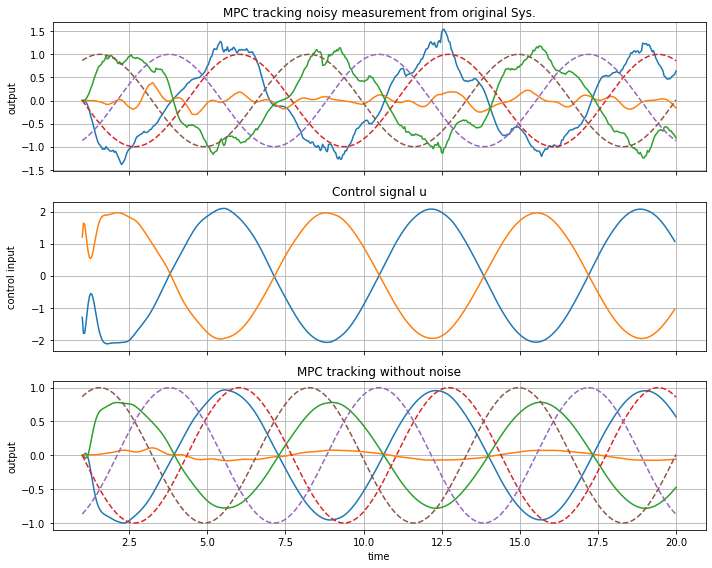

In [15]:
## results visualization ##
res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))

res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].plot(time,REFERENCE.T[:N_sim], '--')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].plot(time,REFERENCE.T[:N_sim], '--')
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Acceleration_signal',dpi=250)